<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/NN_prediction_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization

In [22]:
df = pd.read_csv('UsdRubTime.csv', delimiter=';', decimal='.')

In [23]:
df.head()

,Close,Data,Position
0,0.988,22.08.1993,1
1,0.993,29.08.1993,8
2,1.000,05.09.1993,15
3,1.020,12.09.1993,22
4,1.300,19.09.1993,29


In [24]:
df_close = pd.DataFrame(df['Close'])

In [25]:
df_data = pd.to_datetime(df['Data'], dayfirst=True)

In [26]:
df_data.head()

,Data
0,1993-08-22
1,1993-08-29
2,1993-09-05
3,1993-09-12
4,1993-09-19


In [27]:
df_close.index = pd.to_datetime(df['Data'], dayfirst=True)

In [28]:
df_close.head()

,Close
Data,
1993-08-22,0.988
1993-08-29,0.993
1993-09-05,1.000
1993-09-12,1.020
1993-09-19,1.300


In [29]:
df_close.describe()

,Close
count,1542.000000
mean,35.306973
std,21.890677
min,0.988000
25%,25.754750
50%,29.871000
75%,57.287250
max,133.417000


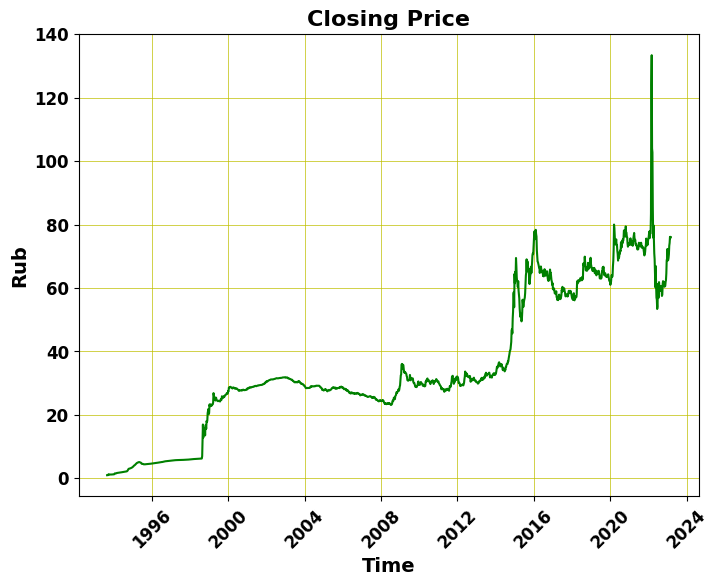

In [30]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df_close, color='g')
plt.title('Closing Price', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Rub', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

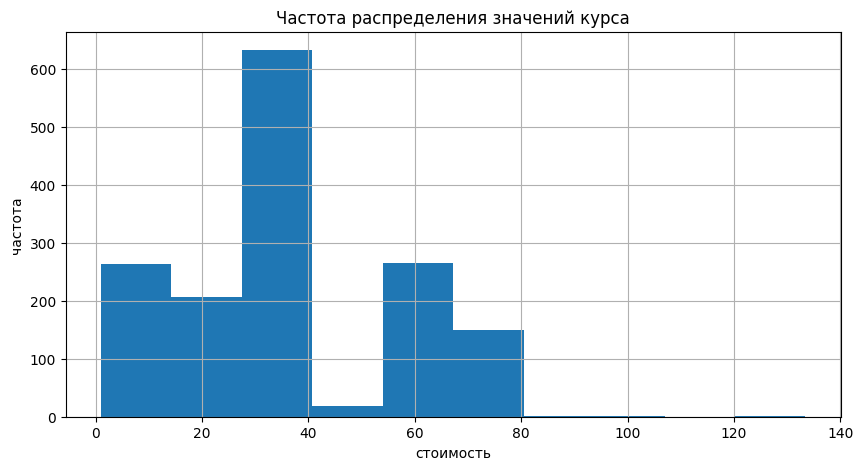

In [61]:
plt.figure(figsize=(10, 5))
plt.hist(df['Close'], bins=10)
plt.title('Частота распределения значений курса')
plt.xlabel('стоимость')
plt.ylabel('частота')
plt.grid(True)
plt.show()

# Модель №1

In [62]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [94]:
train_size = int(len(df_close) * 0.3)
train_data, test_data = df_close[:train_size], df_close[train_size:]

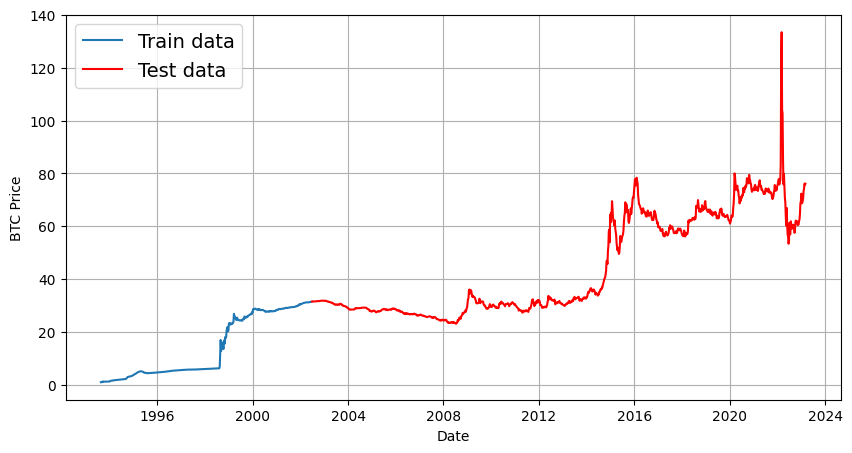

In [95]:
# Plot correctly made splits

plt.figure(figsize=(10, 5))
plt.plot(train_data['Close'], label="Train data")
plt.plot(test_data['Close'], 'r-', label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.grid()
plt.show();

In [96]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Close']])
scaled_test_data = scaler.transform(test_data[['Close']])

In [97]:
# ARIMA model
arima_model = ARIMA(train_data['Close'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [98]:
# LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(np.expand_dims(scaled_train_data, axis=-1),
                              np.expand_dims(scaled_train_data, axis=-1),
                              epochs=5, batch_size=1, verbose=0)
lstm_predictions = lstm_model.predict(np.expand_dims(scaled_test_data, axis=-1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [99]:
lstm_predictions = scaler.inverse_transform(lstm_predictions)

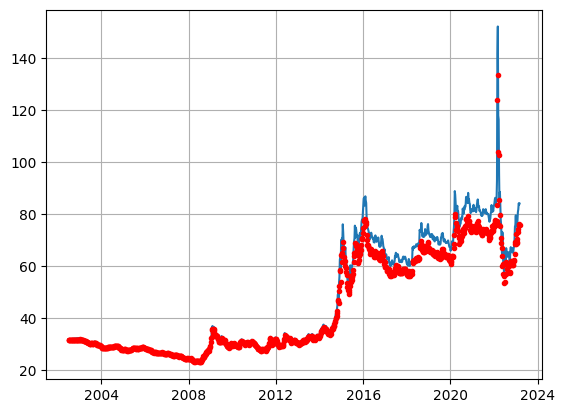

In [100]:
plt.plot(test_data['Close'].index, lstm_predictions)
plt.plot(test_data['Close'].index, test_data['Close'].values, 'r.')
plt.grid()
plt.show()

# Модель №2

In [31]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :

    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """

    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1]
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)

    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [32]:
list_of_attributes = ['Close']

list_of_prev_t_instants = []
for i in range(1,16):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [33]:
df_new = create_regressor_attributes(df_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5),Close_(t-6),Close_(t-7),Close_(t-8),Close_(t-9),Close_(t-10),Close_(t-11),Close_(t-12),Close_(t-13),Close_(t-14),Close_(t-15)
datetime,,,,,,,,,,,,,,,,
1993-12-05,1.232,1.232,1.222,1.206,1.183,1.179,1.187,1.194,1.196,1.194,1.169,1.300,1.020,1.000,0.993,0.988
1993-12-12,1.250,1.232,1.232,1.222,1.206,1.183,1.179,1.187,1.194,1.196,1.194,1.169,1.300,1.020,1.000,0.993
1993-12-19,1.253,1.250,1.232,1.232,1.222,1.206,1.183,1.179,1.187,1.194,1.196,1.194,1.169,1.300,1.020,1.000
1993-12-26,1.250,1.253,1.250,1.232,1.232,1.222,1.206,1.183,1.179,1.187,1.194,1.196,1.194,1.169,1.300,1.020
1994-01-02,1.262,1.250,1.253,1.250,1.232,1.232,1.222,1.206,1.183,1.179,1.187,1.194,1.196,1.194,1.169,1.300


In [34]:
df_new.shape

(1527, 16)

In [35]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
batch = 10
n_samples = 100
timesteps = 15
features = 10

In [53]:
input_layer = keras.Input(shape=(timesteps, features),batch_size=batch)


In [54]:
#input_layer = Input(shape=(10), dtype='float32')
input_layer = keras.Input(shape=(timesteps, features),batch_size=batch)
dense1 = layers.Dense(60, activation='linear')(input_layer)
dense2 = layers.Dense(60, activation='linear')(dense1)
dropout_layer = layers.Dropout(0.2)(dense2)
output_layer = layers.Dense(1, activation='linear')(dropout_layer)

In [40]:
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (20, 15, 10)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (20, 15, 60)                │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (20, 15, 60)                │           3,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (20, 15, 60)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (20, 15, 1)                 │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,381 (17.11 KB)

 Trainable params: 4,381 (17.11 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (1377, 15) (1377,)
Shape of validation inputs, validation target: (73, 15) (73,)
Shape of test inputs, test target: (77, 15) (77,)


In [56]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [57]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=2, epochs=5)

Epoch 1/5


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 15), dtype=float32). Expected shape (20, 15, 10), but input has incompatible shape (None, 15)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 15), dtype=float32)
  • training=True
  • mask=None

In [ ]:
X_train_scaled.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [58]:
model.fit(x=X_train, y=y_train, batch_size=5, epochs=5, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/5


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 15), dtype=float32). Expected shape (20, 15, 10), but input has incompatible shape (None, 15)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 15), dtype=float32)
  • training=True
  • mask=None

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)


In [ ]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

In [ ]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Close Price'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Close Price'])

In [ ]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Bitcoin Stock Closing Prices', weight='bold', fontsize=16)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()